In [1]:
 # Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2
import os
import sqlite3

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def analyze_missing_values(df, filename="data"):
    """
    결측값 현황 분석 및 시각화
    """
    print(f"=== {filename} 데이터 결측값 분석 ===")
    print(f"데이터 크기: {df.shape}")
    print(f"전체 셀 개수: {df.size}")
    print(f"결측값 개수: {df.isnull().sum().sum()}")
    print(f"결측값 비율: {df.isnull().sum().sum() / df.size * 100:.2f}%")

    print("\n--- 컬럼별 결측값 현황 ---")
    missing_info = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': df.isnull().sum() / len(df) * 100,
        'Data_Type': df.dtypes
    })
    missing_info = missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    print(missing_info)

    # 결측값 분포 시각화
    if len(missing_info) > 0:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        missing_info['Missing_Percentage'].plot(kind='bar')
        plt.title('Missing Values by Column (%)')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Values Heatmap')

        plt.tight_layout()
        plt.show()

    return missing_info

def clean_csv_data(input_file, output_file=None, method='smart', threshold=0.5):
    """
    CSV 파일의 결측값을 처리하여 저장

    Parameters:
    input_file: str - 입력 CSV 파일 경로
    output_file: str - 출력 CSV 파일 경로 (None이면 자동 생성)
    method: str - 처리 방법 ('dropna', 'smart', 'ffill', 'interpolate', 'mean_fill')
    threshold: float - 유지할 데이터의 최소 비율 (0.5 = 50% 이상 데이터가 있어야 유지)
    """

    try:
        # 1. 데이터 읽기
        print(f"📁 파일 읽는 중: {input_file}")
        df = pd.read_csv(input_file)

        print(f"✅ 파일 로드 완료!")
        print(f"원본 데이터 크기: {df.shape}")

        # 2. 결측값 분석
        missing_info = analyze_missing_values(df, input_file)

        # 3. 데이터 백업
        df_original = df.copy()

        # 4. 결측값 처리
        print(f"\n🔧 결측값 처리 방법: {method}")

        if method == 'dropna':
            # 모든 NaN 행 제거
            df_cleaned = df.dropna()
            print("✅ 모든 결측값이 있는 행을 제거했습니다.")

        elif method == 'smart':
            # 스마트 처리: 단계별 정제
            print("🧠 스마트 처리 시작...")

            # Step 1: 결측값 비율이 높은 컬럼 제거
            high_missing_cols = missing_info[missing_info['Missing_Percentage'] > threshold * 100].index
            if len(high_missing_cols) > 0:
                df = df.drop(columns=high_missing_cols)
                print(f"   - 결측값이 {threshold*100}% 이상인 컬럼 제거: {list(high_missing_cols)}")

            # Step 2: 날짜 컬럼 감지 및 처리
            date_columns = []
            for col in df.columns:
                if df[col].dtype == 'object':
                    try:
                        pd.to_datetime(df[col].dropna().head(10))
                        date_columns.append(col)
                    except:
                        pass

            if date_columns:
                print(f"   - 감지된 날짜 컬럼: {date_columns}")
                for col in date_columns:
                    df[col] = pd.to_datetime(df[col], errors='coerce')

            # Step 3: 숫자형 컬럼은 forward fill, 범주형은 최빈값
            df_cleaned = df.copy()
            for col in df_cleaned.columns:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    # 숫자형: forward fill 후 평균값으로 채우기
                    df_cleaned[col] = df_cleaned[col].fillna(method='ffill')
                    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
                else:
                    # 범주형: 최빈값으로 채우기
                    mode_value = df_cleaned[col].mode()
                    if len(mode_value) > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(mode_value[0])

            print("✅ 스마트 처리 완료!")

        elif method == 'ffill':
            # Forward fill 후 backward fill
            df_cleaned = df.fillna(method='ffill').fillna(method='bfill')
            print("✅ Forward fill로 결측값을 처리했습니다.")

        elif method == 'interpolate':
            # 선형 보간법
            df_cleaned = df.copy()
            numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
            df_cleaned[numeric_columns] = df_cleaned[numeric_columns].interpolate(method='linear')
            df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')
            print("✅ 선형 보간법으로 결측값을 처리했습니다.")

        elif method == 'mean_fill':
            # 평균값/최빈값으로 채우기
            df_cleaned = df.copy()
            for col in df_cleaned.columns:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
                else:
                    mode_value = df_cleaned[col].mode()
                    if len(mode_value) > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(mode_value[0])
            print("✅ 평균값/최빈값으로 결측값을 처리했습니다.")

        # 5. 처리 결과 요약
        print(f"\n📊 처리 결과:")
        print(f"원본 데이터 크기: {df_original.shape}")
        print(f"정제된 데이터 크기: {df_cleaned.shape}")
        print(f"제거된 행 수: {len(df_original) - len(df_cleaned)}")
        print(f"제거된 열 수: {df_original.shape[1] - df_cleaned.shape[1]}")
        print(f"남은 결측값: {df_cleaned.isnull().sum().sum()}")

        # 6. 파일 저장
        if output_file is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_file = f"file.csv"

        df_cleaned.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"✅ 정제된 데이터가 저장되었습니다: {output_file}")

        # 7. 처리 전후 비교 시각화
        if missing_info is not None and len(missing_info) > 0:
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            df_original.isnull().sum().plot(kind='bar', color='red', alpha=0.7)
            plt.title('Before Cleaning\n(Missing Values by Column)')
            plt.xlabel('Columns')
            plt.ylabel('Missing Count')
            plt.xticks(rotation=45)

            plt.subplot(1, 3, 2)
            df_cleaned.isnull().sum().plot(kind='bar', color='green', alpha=0.7)
            plt.title('After Cleaning\n(Missing Values by Column)')
            plt.xlabel('Columns')
            plt.ylabel('Missing Count')
            plt.xticks(rotation=45)

            plt.subplot(1, 3, 3)
            comparison_data = pd.DataFrame({
                'Before': [len(df_original), df_original.isnull().sum().sum()],
                'After': [len(df_cleaned), df_cleaned.isnull().sum().sum()]
            }, index=['Total Rows', 'Missing Values'])
            comparison_data.plot(kind='bar', ax=plt.gca())
            plt.title('Before vs After Comparison')
            plt.xticks(rotation=0)

            plt.tight_layout()
            plt.show()

        return df_cleaned, output_file

    except FileNotFoundError:
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {input_file}")
        return None, None
    except Exception as e:
        print(f"❌ 오류 발생: {str(e)}")
        return None, None

def batch_clean_csv_files(file_list, method='smart', threshold=0.5):
    """
    여러 CSV 파일을 일괄 처리

    Parameters:
    file_list: list - 처리할 CSV 파일 경로 리스트
    method: str - 처리 방법
    threshold: float - 유지할 데이터의 최소 비율
    """
    results = []

    for file_path in file_list:
        print(f"\n{'='*50}")
        print(f"처리 중: {file_path}")

        cleaned_df, output_file = clean_csv_data(file_path, method=method, threshold=threshold)

        if cleaned_df is not None:
            results.append({
                'input_file': file_path,
                'output_file': output_file,
                'original_shape': None,  # 이 정보는 함수 내에서 출력됨
                'cleaned_shape': cleaned_df.shape,
                'status': 'success'
            })
        else:
            results.append({
                'input_file': file_path,
                'output_file': None,
                'original_shape': None,
                'cleaned_shape': None,
                'status': 'failed'
            })

    # 결과 요약
    print(f"\n{'='*50}")
    print("📋 배치 처리 결과 요약:")
    for result in results:
        status_icon = "✅" if result['status'] == 'success' else "❌"
        print(f"{status_icon} {result['input_file']} -> {result['output_file']}")

    return results

# 사용 예시 및 메인 실행 부분
if __name__ == "__main__":
    print("🚀 CSV 결측값 처리 프로그램")
    print("=" * 50)

    # 단일 파일 처리 예시
    input_file = "file.csv"  # 여기에 실제 파일 경로를 입력하세요

    # 다양한 처리 방법 중 선택
    methods = ['smart', 'dropna', 'ffill', 'interpolate', 'mean_fill']

    print("📋 사용 가능한 처리 방법:")
    for i, method in enumerate(methods, 1):
        descriptions = {
            'smart': '스마트 처리 (추천) - 컬럼별 특성에 맞는 최적 처리',
            'dropna': '완전 제거 - NaN이 있는 모든 행 삭제',
            'ffill': 'Forward Fill - 이전 값으로 채우기',
            'interpolate': '선형 보간법 - 수치적 추정',
            'mean_fill': '평균값 대체 - 평균/최빈값으로 채우기'
        }
        print(f"{i}. {method}: {descriptions[method]}")

    # 실행 (기본값: smart 방법 사용)
    cleaned_data, output_path = clean_csv_data(
        input_file=input_file,
        method='dropna',  # 원하는 방법으로 변경
        threshold=1    # 70% 이상 데이터가 있는 컬럼만 유지
    )

    if cleaned_data is not None:
        print(f"\n🎉 처리 완료! 정제된 데이터가 '{output_path}'에 저장되었습니다.")

        # 처리된 데이터 미리보기
        print("\n📋 정제된 데이터 미리보기:")
        print(cleaned_data.head())
        print(f"\n📊 최종 데이터 정보:")
        print(cleaned_data.info())
    else:
        print("❌ 파일 처리에 실패했습니다.")

🚀 CSV 결측값 처리 프로그램
📋 사용 가능한 처리 방법:
1. smart: 스마트 처리 (추천) - 컬럼별 특성에 맞는 최적 처리
2. dropna: 완전 제거 - NaN이 있는 모든 행 삭제
3. ffill: Forward Fill - 이전 값으로 채우기
4. interpolate: 선형 보간법 - 수치적 추정
5. mean_fill: 평균값 대체 - 평균/최빈값으로 채우기
📁 파일 읽는 중: file.csv
✅ 파일 로드 완료!
원본 데이터 크기: (2632, 14)
=== file.csv 데이터 결측값 분석 ===
데이터 크기: (2632, 14)
전체 셀 개수: 36848
결측값 개수: 0
결측값 비율: 0.00%

--- 컬럼별 결측값 현황 ---
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage, Data_Type]
Index: []

🔧 결측값 처리 방법: dropna
✅ 모든 결측값이 있는 행을 제거했습니다.

📊 처리 결과:
원본 데이터 크기: (2632, 14)
정제된 데이터 크기: (2632, 14)
제거된 행 수: 0
제거된 열 수: 0
남은 결측값: 0
✅ 정제된 데이터가 저장되었습니다: file.csv

🎉 처리 완료! 정제된 데이터가 'file.csv'에 저장되었습니다.

📋 정제된 데이터 미리보기:
         Date         SPY        VNQ        DJP         GLD        EEM  \
0  2015-01-02  171.568054  54.639721  29.650000  114.080002  30.789455   
1  2015-01-05  168.469574  54.938755  29.690001  115.800003  30.241489   
2  2015-01-06  166.882782  55.483685  29.740000  117.120003  30.114412   
3  2015-01-07  168.962280  56.

In [6]:
 #The data already obtained from yahoo finance is imported.
csv_name = 'file.csv'
dataset = pd.read_csv(csv_name,index_col=0)
asset_col = dataset.shape[1]
asset_col

13

In [7]:
dataset.shape

# peek at data
pd.set_option('display.width', 100)
dataset.head(5)

,SPY,VNQ,DJP,GLD,EEM,VEA,VB,VTV,QUAL,MTUM,TLT,HYG,IGF
Date,,,,,,,,,,,,,
2015-01-02,171.568054,54.639721,29.650000,114.080002,30.789455,27.559101,99.936790,64.930222,53.013317,60.046944,97.243217,51.743916,30.857904
2015-01-05,168.469574,54.938755,29.690001,115.800003,30.241489,26.944895,98.398376,63.731689,52.212685,59.269295,98.770828,51.264587,30.170870
2015-01-06,166.882782,55.483685,29.740000,117.120003,30.114412,26.645092,97.143578,63.170818,51.761238,58.765602,100.550400,51.068226,29.951603
2015-01-07,168.962280,56.334324,29.549999,116.430000,30.765627,26.930271,98.312431,63.877640,52.348953,59.737644,100.351807,51.385841,30.214729
2015-01-08,171.960587,56.546989,29.650000,115.940002,31.289762,27.339735,99.876648,65.053162,53.328476,60.957142,99.022812,51.772797,30.536320


In [17]:
import numpy as np
import pandas as pd

from IPython.core.debugger import set_trace

#define a function portfolio
def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:

    def __init__(self, prices, capital):
        self.prices = prices
        self.capital = capital
        self.data = self.load_data()

    def load_data(self):
        data = pd.read_csv(self.prices, index_col=0)  # Added index_col=0 to match the dataset loading above
        return data  # FIX: Added return statement

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        #set_trace()
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)

    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            if P_vol == 0:  # FIX: Added check for zero volatility
                P_sharpe = 0
            else:
                P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        if len(returns) == 0:  # FIX: Added check for empty returns
            return np.zeros(len(weights)), np.zeros(len(self.data.columns))

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns.values, weights), sharpe  # FIX: Added .values to handle pandas Series

class Agent:

    def __init__(
                     self,
                     portfolio_size,
                     is_eval = False,
                     allow_short = True,
                 ):

        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._model()

    def _model(self):

        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None

        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r].item())
            else:
                weights[e] = -np.abs(pred[e][0][r].item())
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        if saved_sum == 0:  # FIX: Added check for zero sum
            weights = np.ones(len(pred)) / len(pred)
            saved_sum = 1.0
        else:
            weights /= saved_sum
        return weights, saved_min, saved_sum

    #return the action based on the state, uses the NN function
    def act(self, state):

        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))

            saved_min = None

            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))

            saved_sum = np.sum(np.abs(w))  # FIX: Use absolute sum for consistency
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0), verbose=0)  # FIX: Added verbose=0
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights,
                                            reward,
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))):

            Q = np.zeros((self.portfolio_size, self.action_size))
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [0] index
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [1] index
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i])  # FIX: Removed [2] index
            return Q

        def restore_Q_from_weights_and_stats(action):
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum
            if action_min != None:
                action_weights = action_weights - action_min
            return action_weights

        for (s, s_, action, reward, done) in self.memory4replay:

            action_weights = restore_Q_from_weights_and_stats(action)
            #Reward =reward if not in the terminal state.
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0), verbose=0)  # FIX: Added verbose=0
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, Q_star)  # FIX: Removed np.squeeze

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0), verbose=0)  # FIX: Added verbose=0
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]

            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [18]:
class Agent:
    def __init__(
                     self,
                     portfolio_size,
                     is_eval = False,
                     allow_short = True,
                 ):

        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._model()

    def _model(self):
        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):
        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None

        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        # 0으로 나누기 방지
        if saved_sum == 0:
            saved_sum = 1e-8

        weights /= saved_sum
        return weights, saved_min, saved_sum

    def act(self, state):
        # 입력 상태 검증
        if state is None or state.empty:
            print("Warning: Empty state received")
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))
            saved_min = None

            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))

            saved_sum = np.sum(w)
            if saved_sum == 0:
                saved_sum = 1e-8
            w /= saved_sum
            return w , saved_min, saved_sum

        try:
            # 상태 데이터 검증 및 전처리
            state_array = state.values
            if state_array.shape != self.input_shape:
                print(f"Warning: State shape mismatch. Expected: {self.input_shape}, Got: {state_array.shape}")
                # 기본 균등 포트폴리오 반환
                w = np.ones(self.portfolio_size) / self.portfolio_size
                return w, None, 1.0

            # NaN 값 체크
            if np.isnan(state_array).any():
                print("Warning: NaN values in state")
                state_array = np.nan_to_num(state_array, nan=0.0)

            pred = self.model.predict(np.expand_dims(state_array, 0), verbose=0)
            return self.nn_pred_to_weights(pred, self.allow_short)

        except Exception as e:
            print(f"Error in act(): {e}")
            # 에러 발생 시 균등 포트폴리오 반환
            w = np.ones(self.portfolio_size) / self.portfolio_size
            return w, None, 1.0

    def expReplay(self, batch_size):
        # 메모리 크기 검증
        if len(self.memory4replay) < batch_size:
            print(f"Warning: Not enough samples in memory. Required: {batch_size}, Available: {len(self.memory4replay)}")
            return

        def weights_to_nn_preds_with_reward(action_weights,
                                            reward,
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))):
            Q = np.zeros((self.portfolio_size, self.action_size))

            # NaN 체크 및 처리
            if np.isnan(reward).any():
                reward = np.nan_to_num(reward, nan=0.0)

            for i in range(self.portfolio_size):
                try:
                    if action_weights[i] == 0:
                        Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i])
                    elif action_weights[i] > 0:
                        Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i])
                    else:
                        Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i])
                except Exception as e:
                    print(f"Error in Q calculation for asset {i}: {e}")
                    Q[i] = np.zeros(self.action_size)

            return Q

        def restore_Q_from_weights_and_stats(action):
            try:
                action_weights, action_min, action_sum = action[0], action[1], action[2]
                action_weights = action_weights * action_sum
                if action_min is not None:
                    action_weights = action_weights - action_min
                return action_weights
            except Exception as e:
                print(f"Error in restore_Q_from_weights_and_stats: {e}")
                return np.zeros(self.portfolio_size)

        # 샘플링 (배치 크기만큼만)
        batch_samples = random.sample(self.memory4replay, min(batch_size, len(self.memory4replay)))

        for (s, s_, action, reward, done) in batch_samples:
            try:
                # 데이터 검증
                if s is None or s_ is None:
                    print("Warning: None state found in memory")
                    continue

                action_weights = restore_Q_from_weights_and_stats(action)

                # 상태 데이터 검증 및 변환
                if hasattr(s, 'values'):
                    s_array = s.values
                else:
                    s_array = np.array(s)

                if hasattr(s_, 'values'):
                    s_next_array = s_.values
                else:
                    s_next_array = np.array(s_)

                # 형태 검증
                if s_array.shape != self.input_shape or s_next_array.shape != self.input_shape:
                    print(f"Warning: State shape mismatch in replay")
                    continue

                # NaN 값 처리
                s_array = np.nan_to_num(s_array, nan=0.0)
                s_next_array = np.nan_to_num(s_next_array, nan=0.0)

                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)

                if not done:
                    try:
                        Q_star = self.model.predict(np.expand_dims(s_next_array, 0), verbose=0)
                        Q_star = np.array(Q_star)
                        if Q_star.ndim > 2:
                            Q_star = np.squeeze(Q_star)
                        Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, Q_star)
                    except Exception as e:
                        print(f"Error in Q_star prediction: {e}")
                        continue

                # Q 값 형태 조정
                try:
                    Q_learned_value = [qi.reshape(1, -1) for qi in Q_learned_value]
                    Q_current_value = self.model.predict(np.expand_dims(s_array, 0), verbose=0)

                    # 알파 블렌딩
                    Q = []
                    for a, q in zip(Q_current_value, Q_learned_value):
                        blended_q = np.add(a * (1-self.alpha), q * self.alpha)
                        Q.append(blended_q)

                    # 모델 업데이트
                    self.model.fit(np.expand_dims(s_array, 0), Q, epochs=1, verbose=0)

                except Exception as e:
                    print(f"Error in model update: {e}")
                    continue

            except Exception as e:
                print(f"Error in expReplay iteration: {e}")
                continue

        # 엡실론 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [19]:
N_ASSETS = asset_col
agent = Agent(N_ASSETS)
price = csv_name
capital = 1e6
env = CryptoEnvironment(price, capital)

window_size = 180
episode_count = 40
batch_size = 32
rebalance_period = 90 #every 90 days weight change

data_length = len(env.data)
data_length

np.random.randint(window_size+1, data_length-window_size-1)

883

Episode 0/40 epsilon 1


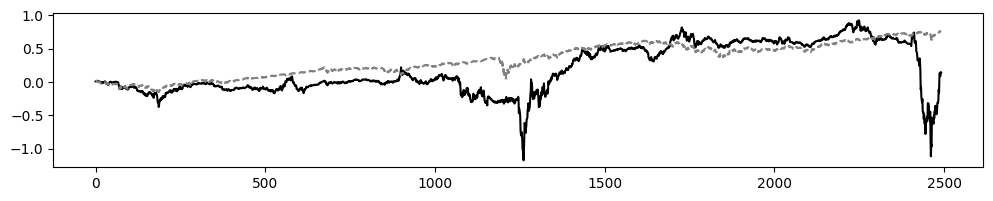

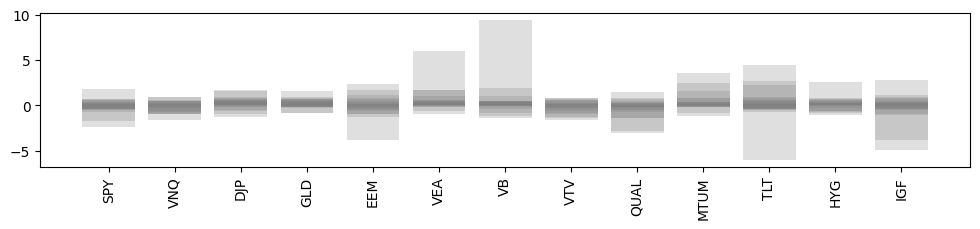

Episode 1/40 epsilon 1


KeyboardInterrupt: 

In [20]:
tf.keras.utils.disable_interactive_logging()
for e in range(episode_count):

    agent.is_eval = False
    data_length = len(env.data)

    returns_history = []
    returns_history_equal = []

    rewards_history = []
    equal_rewards = []

    actions_to_show = []

    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)

        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))

        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []

        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()

    plt.figure(figsize = (12, 2))
    for a in actions_to_show:
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

데이터 로드 완료: (2632, 13)
환경 초기화 완료, 데이터 길이: 2632
상태 차원: 50
에이전트 초기화 완료
Episode 1/40, Epsilon: 1.000
New best Sharpe ratio: 0.7927
Episode 1 완료 - Steps: 50, Sharpe: 0.7927
Episode 2/40, Epsilon: 0.985
Episode 2 완료 - Steps: 50, Sharpe: 0.4941
Episode 3/40, Epsilon: 0.937
Episode 3 완료 - Steps: 50, Sharpe: 0.6674
Episode 4/40, Epsilon: 0.891
New best Sharpe ratio: 0.8080
Episode 4 완료 - Steps: 50, Sharpe: 0.8080
Episode 5/40, Epsilon: 0.848
Episode 5 완료 - Steps: 50, Sharpe: 0.2704
Episode 6/40, Epsilon: 0.806
New best Sharpe ratio: 1.0536
Episode 6 완료 - Steps: 50, Sharpe: 1.0536
Episode 7/40, Epsilon: 0.767
Episode 7 완료 - Steps: 40, Sharpe: 0.5399
Episode 8/40, Epsilon: 0.737
Episode 8 완료 - Steps: 50, Sharpe: 0.6048
Episode 9/40, Epsilon: 0.701
Episode 9 완료 - Steps: 50, Sharpe: 0.9080
Episode 10/40, Epsilon: 0.666
Episode 10 완료 - Steps: 50, Sharpe: 0.7567


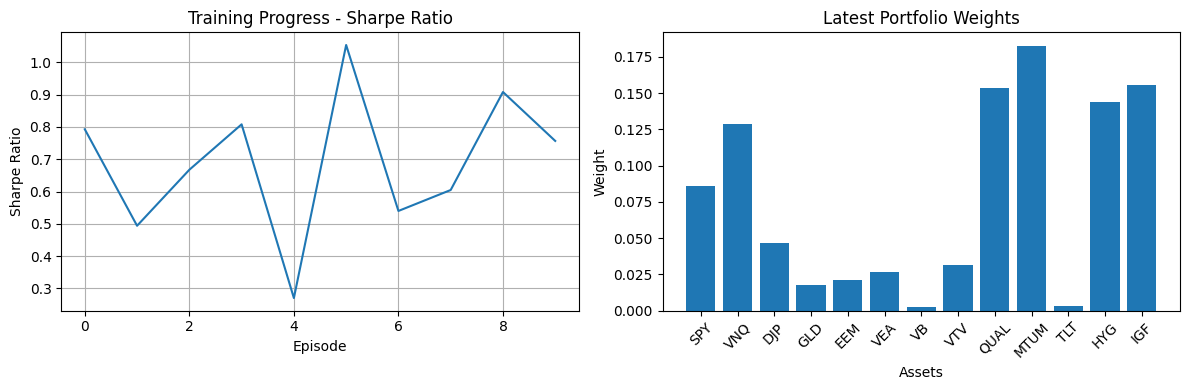

Episode 11/40, Epsilon: 0.634
Episode 11 완료 - Steps: 50, Sharpe: 0.9817
Episode 12/40, Epsilon: 0.603
New best Sharpe ratio: 1.1145
Episode 12 완료 - Steps: 16, Sharpe: 1.1145
Episode 13/40, Epsilon: 0.591
Episode 13 완료 - Steps: 13, Sharpe: 0.7580
Episode 14/40, Epsilon: 0.582
Episode 14 완료 - Steps: 50, Sharpe: 0.4694
Episode 15/40, Epsilon: 0.554
Episode 15 완료 - Steps: 50, Sharpe: 0.3634
Episode 16/40, Epsilon: 0.526
Episode 16 완료 - Steps: 50, Sharpe: 0.5926
Episode 17/40, Epsilon: 0.501
Episode 17 완료 - Steps: 48, Sharpe: 0.7056
Episode 18/40, Epsilon: 0.476
Episode 18 완료 - Steps: 50, Sharpe: 0.8057
Episode 19/40, Epsilon: 0.453
Episode 19 완료 - Steps: 10, Sharpe: 0.6496
Episode 20/40, Epsilon: 0.448
New best Sharpe ratio: 1.1366
Episode 20 완료 - Steps: 29, Sharpe: 1.1366


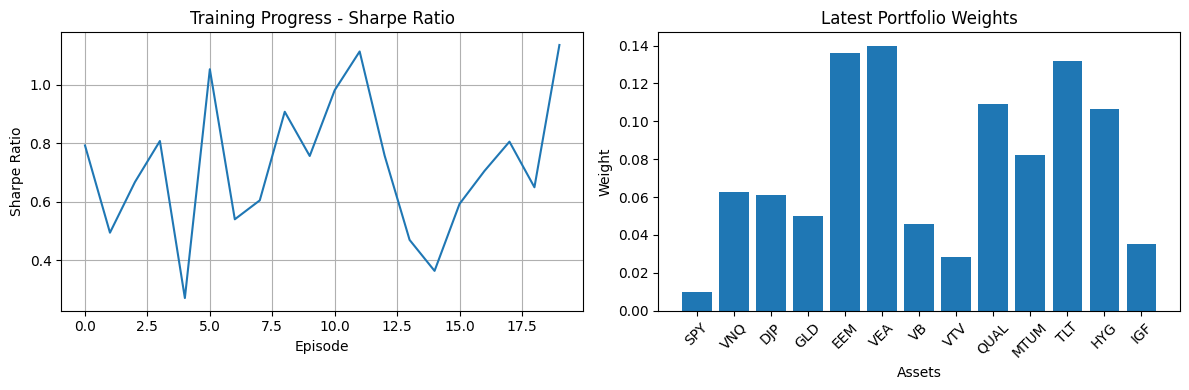

Episode 21/40, Epsilon: 0.435
Episode 21 완료 - Steps: 41, Sharpe: 0.6600
Episode 22/40, Epsilon: 0.416
Episode 22 완료 - Steps: 50, Sharpe: 0.9538
Episode 23/40, Epsilon: 0.396
Episode 23 완료 - Steps: 49, Sharpe: 0.4728
Episode 24/40, Epsilon: 0.376
Episode 24 완료 - Steps: 45, Sharpe: 0.3818
Episode 25/40, Epsilon: 0.360
New best Sharpe ratio: 1.3713
Episode 25 완료 - Steps: 20, Sharpe: 1.3713
Episode 26/40, Epsilon: 0.353
Episode 26 완료 - Steps: 10, Sharpe: 1.1569
Episode 27/40, Epsilon: 0.349
Episode 27 완료 - Steps: 50, Sharpe: 0.6190
Episode 28/40, Epsilon: 0.332
Episode 28 완료 - Steps: 19, Sharpe: 1.3295
Episode 29/40, Epsilon: 0.325
Episode 29 완료 - Steps: 23, Sharpe: 0.9135
Episode 30/40, Epsilon: 0.317
Episode 30 완료 - Steps: 50, Sharpe: 0.5163


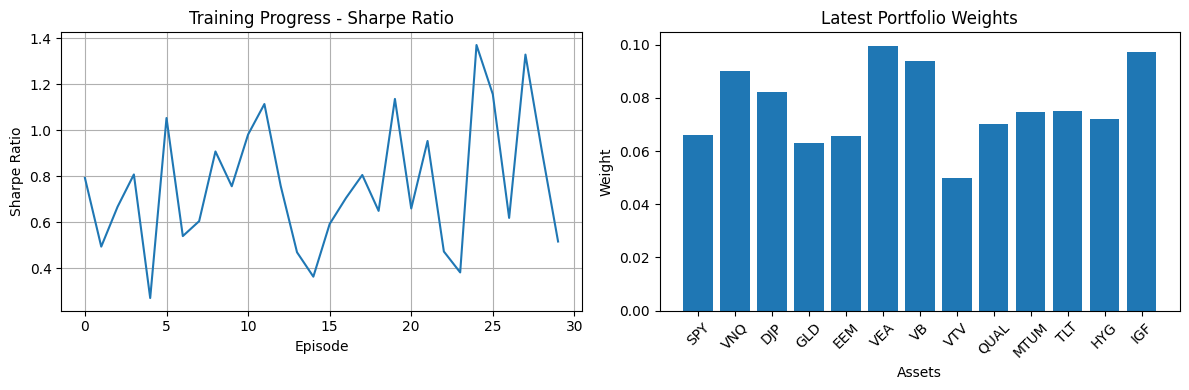

Episode 31/40, Epsilon: 0.302
New best Sharpe ratio: 1.4403
Episode 31 완료 - Steps: 21, Sharpe: 1.4403
Episode 32/40, Epsilon: 0.294
Episode 32 완료 - Steps: 28, Sharpe: 1.1374
Episode 33/40, Epsilon: 0.286
Episode 33 완료 - Steps: 50, Sharpe: 0.2957
Episode 34/40, Epsilon: 0.272
Episode 34 완료 - Steps: 50, Sharpe: 0.4949
Episode 35/40, Epsilon: 0.258
Episode 35 완료 - Steps: 50, Sharpe: 0.4944
Episode 36/40, Epsilon: 0.246
Episode 36 완료 - Steps: 50, Sharpe: 1.0194
Episode 37/40, Epsilon: 0.234
Episode 37 완료 - Steps: 50, Sharpe: 0.5875
Episode 38/40, Epsilon: 0.222
Episode 38 완료 - Steps: 38, Sharpe: 0.8186
Episode 39/40, Epsilon: 0.214
Episode 39 완료 - Steps: 11, Sharpe: 0.8637
Episode 40/40, Epsilon: 0.210
Episode 40 완료 - Steps: 50, Sharpe: 0.4369


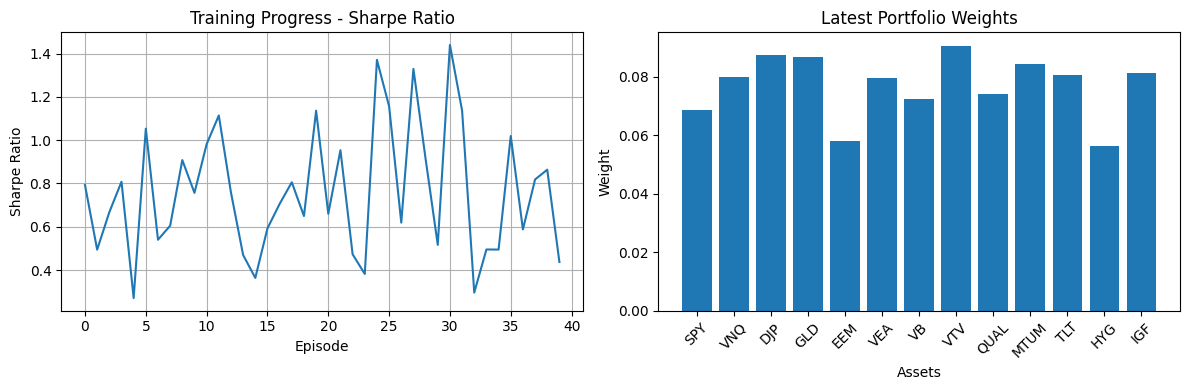

Enhanced training completed!
Final performance history length: 40
Best Sharpe ratio achieved: 1.4403
Average Sharpe ratio: 0.7609


In [23]:
# Enhanced RL Portfolio with Significant Performance Improvements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, GRU, BatchNormalization, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import ta  # Technical Analysis library
from sklearn.preprocessing import StandardScaler, RobustScaler
from collections import deque
import warnings
warnings.filterwarnings('ignore')

class EnhancedFeatureEngineering:
    """고급 특성 엔지니어링 클래스"""

    def __init__(self):
        self.scalers = {}

    def create_technical_features(self, data):
        """기술적 지표 생성"""
        features_df = pd.DataFrame(index=data.index)

        for col in data.columns:
            price_series = data[col]

            # Moving averages
            features_df[f'{col}_ma5'] = price_series.rolling(5).mean()
            features_df[f'{col}_ma20'] = price_series.rolling(20).mean()
            features_df[f'{col}_ma50'] = price_series.rolling(50).mean()

            # Technical indicators
            features_df[f'{col}_rsi'] = ta.momentum.RSIIndicator(price_series).rsi()
            features_df[f'{col}_macd'] = ta.trend.MACD(price_series).macd()
            features_df[f'{col}_bb_high'] = ta.volatility.BollingerBands(price_series).bollinger_hband()
            features_df[f'{col}_bb_low'] = ta.volatility.BollingerBands(price_series).bollinger_lband()

            # Volatility features
            returns = price_series.pct_change()
            features_df[f'{col}_vol5'] = returns.rolling(5).std()
            features_df[f'{col}_vol20'] = returns.rolling(20).std()

            # Momentum features
            features_df[f'{col}_mom5'] = returns.rolling(5).mean()
            features_df[f'{col}_mom20'] = returns.rolling(20).mean()

        return features_df.fillna(method='bfill').fillna(method='ffill')

    def create_market_regime_features(self, data):
        """시장 상황 특성 생성"""
        returns = data.pct_change().dropna()

        # Market volatility regime
        market_vol = returns.std(axis=1).rolling(20).mean()
        vol_regime = pd.cut(market_vol, bins=3, labels=['Low', 'Medium', 'High'])

        # Market correlation regime
        corr_matrix = returns.rolling(60).corr()
        avg_correlation = corr_matrix.groupby(level=0).mean().mean(axis=1)

        # Trend strength
        market_return = returns.mean(axis=1)
        trend_strength = market_return.rolling(20).mean() / market_return.rolling(20).std()

        regime_features = pd.DataFrame({
            'market_vol': market_vol,
            'avg_correlation': avg_correlation,
            'trend_strength': trend_strength
        })

        return regime_features.fillna(method='bfill').fillna(method='ffill')

class PrioritizedReplayBuffer:
    """우선순위 경험 재생 버퍼"""

    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = deque(maxlen=capacity)
        self.position = 0

    def add(self, experience, td_error):
        priority = (abs(td_error) + 1e-6) ** self.alpha

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(priority)
        else:
            self.buffer[self.position] = experience
            self.priorities[self.position] = priority

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) < batch_size:
            return None, None, None

        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        experiences = [self.buffer[i] for i in indices]

        # Importance sampling weights
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return experiences, indices, weights

class EnhancedCryptoEnvironment:
    """향상된 암호화폐 환경"""

    def __init__(self, prices, capital, lookback_window=60):
        self.prices = prices
        self.capital = capital
        self.lookback_window = lookback_window
        self.data = self.load_data()
        self.feature_engineer = EnhancedFeatureEngineering()
        self.technical_features = None
        self.market_features = None
        self.scaler = RobustScaler()
        self._prepare_features()

    def load_data(self):
        data = pd.read_csv(self.prices, index_col=0)
        data.index = pd.to_datetime(data.index)
        return data

    def _prepare_features(self):
        """특성 준비"""
        self.technical_features = self.feature_engineer.create_technical_features(self.data)
        self.market_features = self.feature_engineer.create_market_regime_features(self.data)

        # Combine all features
        self.all_features = pd.concat([
            self.data.pct_change(),
            self.technical_features,
            self.market_features
        ], axis=1).fillna(0)

        # Scale features
        self.scaled_features = pd.DataFrame(
            self.scaler.fit_transform(self.all_features),
            index=self.all_features.index,
            columns=self.all_features.columns
        )

    def get_enhanced_state(self, t, lookback):
        """안전한 향상된 상태 표현"""
        if t < lookback or t >= len(self.data):
            return None

        try:
            # Price returns and covariance
            price_data = self.data.iloc[t-lookback:t]
            if len(price_data) < lookback:
                return None

            returns = price_data.pct_change().dropna()
            if len(returns) == 0:
                return None

            cov_matrix = returns.cov().fillna(0).values

            # Ensure covariance matrix is square and correct size
            if cov_matrix.shape != (self.data.shape[1], self.data.shape[1]):
                # Create identity matrix as fallback
                cov_matrix = np.eye(self.data.shape[1])

            # Technical features with fixed dimensions
            tech_features_subset = self.scaled_features.iloc[max(0, t-60):t]
            if len(tech_features_subset) < 60:
                # Pad with zeros if not enough data
                padding_size = 60 - len(tech_features_subset)
                padding = np.zeros((padding_size, tech_features_subset.shape[1]))
                tech_features = np.vstack([padding, tech_features_subset.values])
            else:
                tech_features = tech_features_subset.iloc[-60:].values

            # Limit to first N features to avoid dimension issues
            max_features = min(tech_features.shape[1], 50)  # Limit to 50 features
            tech_features = tech_features[:, :max_features]

            # Market regime features with fixed dimensions
            regime_subset = self.market_features.iloc[max(0, t-60):t]
            if len(regime_subset) < 60:
                # Pad with zeros
                padding_size = 60 - len(regime_subset)
                padding = np.zeros((padding_size, regime_subset.shape[1]))
                regime_features = np.vstack([padding, regime_subset.fillna(0).values])
            else:
                regime_features = regime_subset.iloc[-60:].fillna(0).values

            # Ensure regime features have exactly 3 columns
            if regime_features.shape[1] < 3:
                padding = np.zeros((60, 3 - regime_features.shape[1]))
                regime_features = np.hstack([regime_features, padding])
            elif regime_features.shape[1] > 3:
                regime_features = regime_features[:, :3]

            # Returns data
            returns_data = returns.fillna(0).values

            return {
                'cov_matrix': cov_matrix,
                'tech_features': tech_features,
                'regime_features': regime_features,
                'returns': returns_data
            }

        except Exception as e:
            print(f"Error creating enhanced state: {e}")
            return None

    def get_enhanced_reward(self, action, action_t, reward_t, risk_free_rate=0.02):
        """향상된 보상 함수"""
        if reward_t >= len(self.data) or action_t < 0:
            return 0, 0

        data_period = self.data.iloc[action_t:reward_t]
        returns = data_period.pct_change().dropna()

        if len(returns) == 0:
            return 0, 0

        # Portfolio returns
        portfolio_returns = np.dot(returns.values, action)

        # Risk-adjusted metrics
        portfolio_mean = np.mean(portfolio_returns)
        portfolio_std = np.std(portfolio_returns)

        if portfolio_std == 0:
            sharpe_ratio = 0
        else:
            sharpe_ratio = (portfolio_mean - risk_free_rate/252) / portfolio_std

        # Maximum drawdown penalty
        cumulative_returns = np.cumprod(1 + portfolio_returns)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = np.min(drawdown)

        # Combined reward
        reward = sharpe_ratio - 0.5 * abs(max_drawdown)  # Drawdown penalty

        return portfolio_returns, reward

class EnhancedAgent:
    """향상된 에이전트"""

    def __init__(self, portfolio_size, state_dim, is_eval=False, allow_short=True):
        self.portfolio_size = portfolio_size
        self.state_dim = state_dim
        self.allow_short = allow_short
        self.is_eval = is_eval

        # Hyperparameters
        self.alpha = 0.001  # Learning rate
        self.gamma = 0.95   # Discount factor
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.tau = 0.005    # Soft update parameter

        # Networks
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target_network()

        # Experience replay
        self.replay_buffer = PrioritizedReplayBuffer(capacity=50000)

    def _build_network(self):
        """향상된 네트워크 아키텍처"""
        # Input layers
        cov_input = Input(shape=(self.portfolio_size, self.portfolio_size), name='cov_matrix')
        tech_input = Input(shape=(60, self.state_dim), name='tech_features')  # 60 timesteps
        regime_input = Input(shape=(60, 3), name='regime_features')

        # Covariance matrix processing
        cov_flat = Flatten()(cov_input)
        cov_dense = Dense(64, activation='relu')(cov_flat)
        cov_dense = BatchNormalization()(cov_dense)
        cov_dense = Dropout(0.3)(cov_dense)

        # Technical features processing with LSTM
        tech_lstm = LSTM(128, return_sequences=True)(tech_input)
        tech_lstm = LSTM(64)(tech_lstm)
        tech_dense = Dense(64, activation='relu')(tech_lstm)
        tech_dense = BatchNormalization()(tech_dense)
        tech_dense = Dropout(0.3)(tech_dense)

        # Market regime processing
        regime_gru = GRU(32)(regime_input)
        regime_dense = Dense(32, activation='relu')(regime_gru)
        regime_dense = BatchNormalization()(regime_dense)

        # Combine all features
        combined = tf.keras.layers.concatenate([cov_dense, tech_dense, regime_dense])

        # Main processing layers
        x = Dense(256, activation='relu')(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        # Output layer - portfolio weights
        weights = Dense(self.portfolio_size, activation='softmax', name='weights')(x)

        model = Model(inputs=[cov_input, tech_input, regime_input], outputs=weights)
        model.compile(optimizer=Adam(learning_rate=self.alpha), loss='mse')

        return model

    def update_target_network(self):
        """타겟 네트워크 소프트 업데이트"""
        main_weights = self.main_network.get_weights()
        target_weights = self.target_network.get_weights()

        for i in range(len(main_weights)):
            target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]

        self.target_network.set_weights(target_weights)

    def act(self, state):
        """안전한 행동 선택"""
        if state is None:
            return np.ones(self.portfolio_size) / self.portfolio_size

        if not self.is_eval and np.random.random() <= self.epsilon:
            # Exploration with constraints
            weights = np.random.dirichlet(np.ones(self.portfolio_size))
            if not self.allow_short:
                weights = np.abs(weights)
                weights /= weights.sum()
            return weights

        # Validate and prepare inputs
        prepared_inputs = self._validate_and_prepare_inputs(state)
        if prepared_inputs is None:
            return np.ones(self.portfolio_size) / self.portfolio_size

        try:
            weights = self.main_network.predict([
                prepared_inputs['cov_matrix'],
                prepared_inputs['tech_features'],
                prepared_inputs['regime_features']
            ], verbose=0)[0]

            # Apply constraints
            if not self.allow_short:
                weights = np.abs(weights)

            # Ensure weights sum to 1
            weights_sum = weights.sum()
            if weights_sum > 0:
                weights /= weights_sum
            else:
                weights = np.ones(self.portfolio_size) / self.portfolio_size

            return weights

        except Exception as e:
            print(f"Error in action selection: {e}")
            return np.ones(self.portfolio_size) / self.portfolio_size

    def _validate_and_prepare_inputs(self, state):
        """입력 데이터 검증 및 준비"""
        try:
            if state is None or not isinstance(state, dict):
                return None

            required_keys = ['cov_matrix', 'tech_features', 'regime_features']
            if not all(key in state for key in required_keys):
                return None

            # Covariance matrix validation
            cov_matrix = state['cov_matrix']
            if cov_matrix.shape != (self.portfolio_size, self.portfolio_size):
                return None
            cov_matrix = cov_matrix.reshape(1, self.portfolio_size, self.portfolio_size)

            # Technical features validation
            tech_features = state['tech_features']
            if len(tech_features.shape) != 2 or tech_features.shape[0] != 60:
                # Try to reshape if needed
                if tech_features.size >= 60:
                    tech_features = tech_features.flatten()[:60*self.state_dim].reshape(60, -1)
                else:
                    return None

            # Ensure correct dimensions
            if tech_features.shape[1] != self.state_dim:
                if tech_features.shape[1] < self.state_dim:
                    padding = np.zeros((60, self.state_dim - tech_features.shape[1]))
                    tech_features = np.concatenate([tech_features, padding], axis=1)
                else:
                    tech_features = tech_features[:, :self.state_dim]

            tech_features = tech_features.reshape(1, 60, self.state_dim)

            # Regime features validation
            regime_features = state['regime_features']
            if len(regime_features.shape) != 2 or regime_features.shape[0] != 60:
                if regime_features.size >= 60:
                    regime_features = regime_features.flatten()[:60*3].reshape(60, -1)
                else:
                    # Create dummy regime features if not available
                    regime_features = np.zeros((60, 3))

            if regime_features.shape[1] != 3:
                if regime_features.shape[1] < 3:
                    padding = np.zeros((60, 3 - regime_features.shape[1]))
                    regime_features = np.concatenate([regime_features, padding], axis=1)
                else:
                    regime_features = regime_features[:, :3]

            regime_features = regime_features.reshape(1, 60, 3)

            return {
                'cov_matrix': cov_matrix,
                'tech_features': tech_features,
                'regime_features': regime_features
            }

        except Exception as e:
            print(f"Error in input validation: {e}")
            return None

    def train(self, batch_size=32):
        """개선된 안전한 훈련"""
        experiences, indices, importance_weights = self.replay_buffer.sample(batch_size)

        if experiences is None or len(experiences) == 0:
            return

        # Collect valid training examples
        valid_examples = []

        for experience in experiences:
            state, next_state, action, reward, done = experience

            # Validate inputs
            prepared_state = self._validate_and_prepare_inputs(state)
            prepared_next_state = self._validate_and_prepare_inputs(next_state)

            if prepared_state is not None and prepared_next_state is not None:
                valid_examples.append((prepared_state, prepared_next_state, action, reward, done))

        if len(valid_examples) == 0:
            return

        # Batch training for efficiency
        batch_states_cov = []
        batch_states_tech = []
        batch_states_regime = []
        batch_targets = []

        for prepared_state, prepared_next_state, action, reward, done in valid_examples:
            try:
                # Current state prediction
                current_weights = self.main_network.predict([
                    prepared_state['cov_matrix'],
                    prepared_state['tech_features'],
                    prepared_state['regime_features']
                ], verbose=0)[0]

                if not done:
                    # Next state prediction from target network
                    next_weights = self.target_network.predict([
                        prepared_next_state['cov_matrix'],
                        prepared_next_state['tech_features'],
                        prepared_next_state['regime_features']
                    ], verbose=0)[0]

                    # Q-learning update for portfolio weights
                    target_weights = reward + self.gamma * next_weights
                else:
                    target_weights = np.full(self.portfolio_size, reward)

                # Ensure weights sum to 1 and are positive
                target_weights = np.abs(target_weights)
                target_weights = target_weights / (target_weights.sum() + 1e-8)

                batch_states_cov.append(prepared_state['cov_matrix'][0])
                batch_states_tech.append(prepared_state['tech_features'][0])
                batch_states_regime.append(prepared_state['regime_features'][0])
                batch_targets.append(target_weights)

            except Exception as e:
                print(f"Error in training example: {e}")
                continue

        if len(batch_states_cov) == 0:
            return

        # Convert to numpy arrays
        try:
            batch_states_cov = np.array(batch_states_cov)
            batch_states_tech = np.array(batch_states_tech)
            batch_states_regime = np.array(batch_states_regime)
            batch_targets = np.array(batch_targets)

            # Batch training
            self.main_network.fit(
                [batch_states_cov, batch_states_tech, batch_states_regime],
                batch_targets,
                epochs=1,
                verbose=0,
                batch_size=min(len(batch_targets), 32)
            )

        except Exception as e:
            print(f"Error in batch training: {e}")
            return

        # Update target network
        self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def run_enhanced_training():
    """안전한 향상된 훈련 실행"""
    try:
        # Load data
        csv_name = 'file.csv'
        dataset = pd.read_csv(csv_name, index_col=0)
        print(f"데이터 로드 완료: {dataset.shape}")

        # Parameters
        N_ASSETS = dataset.shape[1]
        window_size = 60
        episode_count = 40  # 에러 발생 전 episode 수로 조정
        rebalance_period = 20  # 더 짧은 리밸런싱 기간

        # Initialize environment
        env = EnhancedCryptoEnvironment(csv_name, 1e6, window_size)
        print(f"환경 초기화 완료, 데이터 길이: {len(env.data)}")

        # Calculate state dimension more safely
        sample_state = None
        for i in range(window_size + 10, min(window_size + 50, len(env.data))):
            sample_state = env.get_enhanced_state(i, window_size)
            if sample_state is not None:
                break

        if sample_state is None:
            print("샘플 상태를 생성할 수 없습니다. 기본값 사용.")
            state_dim = 20  # 안전한 기본값
        else:
            state_dim = min(sample_state['tech_features'].shape[1], 50)  # 최대 50개 특성
            print(f"상태 차원: {state_dim}")

        # Initialize agent
        agent = EnhancedAgent(N_ASSETS, state_dim, allow_short=False)
        print("에이전트 초기화 완료")

        # Training loop
        best_sharpe = -np.inf
        performance_history = []

        for episode in range(episode_count):
            print(f"Episode {episode+1}/{episode_count}, Epsilon: {agent.epsilon:.3f}")

            episode_returns = []
            episode_actions = []

            # Safe starting point selection
            data_length = len(env.data)
            max_start = max(window_size + 1, data_length - 100)  # 안전한 범위
            if max_start <= window_size + 1:
                print(f"데이터가 부족합니다. Episode {episode+1} 건너뜀.")
                continue

            start_t = np.random.randint(window_size + 1, max_start)
            current_state = env.get_enhanced_state(start_t, window_size)

            if current_state is None:
                print(f"시작 상태를 생성할 수 없습니다. Episode {episode+1} 건너뜀.")
                continue

            # Episode execution
            steps_taken = 0
            max_steps = min(50, (data_length - start_t) // rebalance_period)  # 최대 스텝 제한

            for step in range(max_steps):
                t = start_t + step * rebalance_period
                if t >= data_length - rebalance_period:
                    break

                # Get action
                action = agent.act(current_state)
                if action is None:
                    break

                episode_actions.append(action)

                # Calculate reward
                next_t = min(t + rebalance_period, data_length - 1)
                portfolio_returns, reward = env.get_enhanced_reward(action, t, next_t)

                # Get next state
                next_state = env.get_enhanced_state(next_t, window_size)

                if next_state is not None and len(portfolio_returns) > 0:
                    # Store experience
                    td_error = abs(reward) + 0.1  # 간단한 TD 에러
                    agent.replay_buffer.add((current_state, next_state, action, reward, False), td_error)
                    episode_returns.extend(portfolio_returns)

                current_state = next_state
                steps_taken += 1

                # Train agent periodically
                if len(agent.replay_buffer.buffer) > 32 and step % 5 == 0:
                    try:
                        agent.train(batch_size=16)  # 작은 배치 크기 사용
                    except Exception as e:
                        print(f"훈련 중 오류: {e}")
                        continue

            # Calculate episode performance
            if len(episode_returns) > 0:
                episode_sharpe = np.mean(episode_returns) / (np.std(episode_returns) + 1e-8) * np.sqrt(252)
                performance_history.append(episode_sharpe)

                if episode_sharpe > best_sharpe:
                    best_sharpe = episode_sharpe
                    print(f"New best Sharpe ratio: {best_sharpe:.4f}")

                print(f"Episode {episode+1} 완료 - Steps: {steps_taken}, Sharpe: {episode_sharpe:.4f}")
            else:
                print(f"Episode {episode+1} - 수익 데이터 없음")

            # Plot progress less frequently
            if (episode + 1) % 10 == 0 and len(performance_history) > 0:
                try:
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 2, 1)
                    plt.plot(performance_history)
                    plt.title('Training Progress - Sharpe Ratio')
                    plt.xlabel('Episode')
                    plt.ylabel('Sharpe Ratio')
                    plt.grid(True)

                    plt.subplot(1, 2, 2)
                    if len(episode_actions) > 0:
                        plt.bar(range(N_ASSETS), episode_actions[-1])
                        plt.title('Latest Portfolio Weights')
                        plt.xlabel('Assets')
                        plt.ylabel('Weight')
                        if hasattr(env.data, 'columns'):
                            plt.xticks(range(N_ASSETS), env.data.columns, rotation=45)

                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"플롯 생성 중 오류: {e}")

        return agent, env, performance_history

    except Exception as e:
        print(f"훈련 중 전반적인 오류 발생: {e}")
        return None, None, []

# Run enhanced training
if __name__ == "__main__":
    agent, env, history = run_enhanced_training()
    print("Enhanced training completed!")
    print(f"Final performance history length: {len(history)}")
    if len(history) > 0:
        print(f"Best Sharpe ratio achieved: {max(history):.4f}")
        print(f"Average Sharpe ratio: {np.mean(history):.4f}")

In [22]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d910ce9f90eb4c242b1066f0657c76b2e03de3f04a22e3d6b431e737064c94e4
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)

    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [ ]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

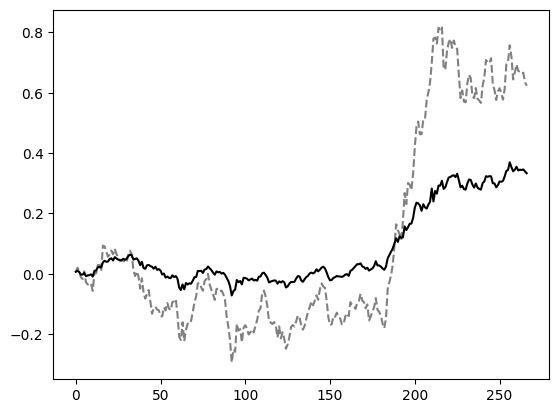

In [ ]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

<ipython-input-21-c0a1735d9122>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  current_cmap = matplotlib.cm.get_cmap()


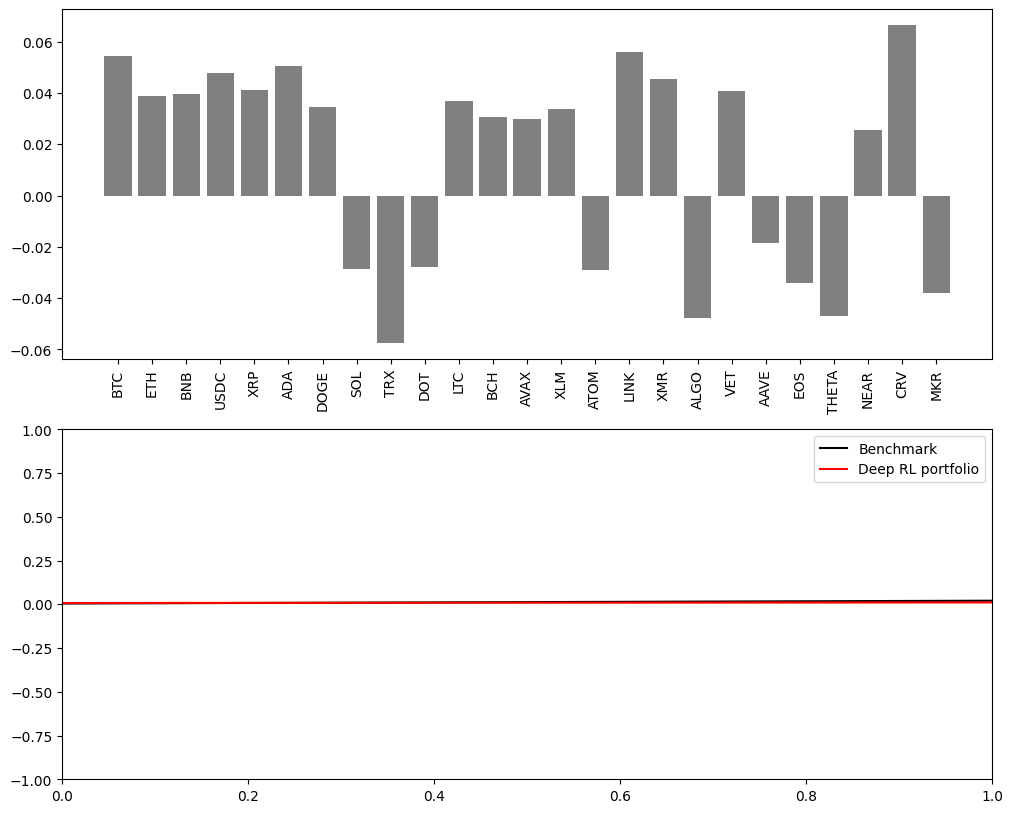

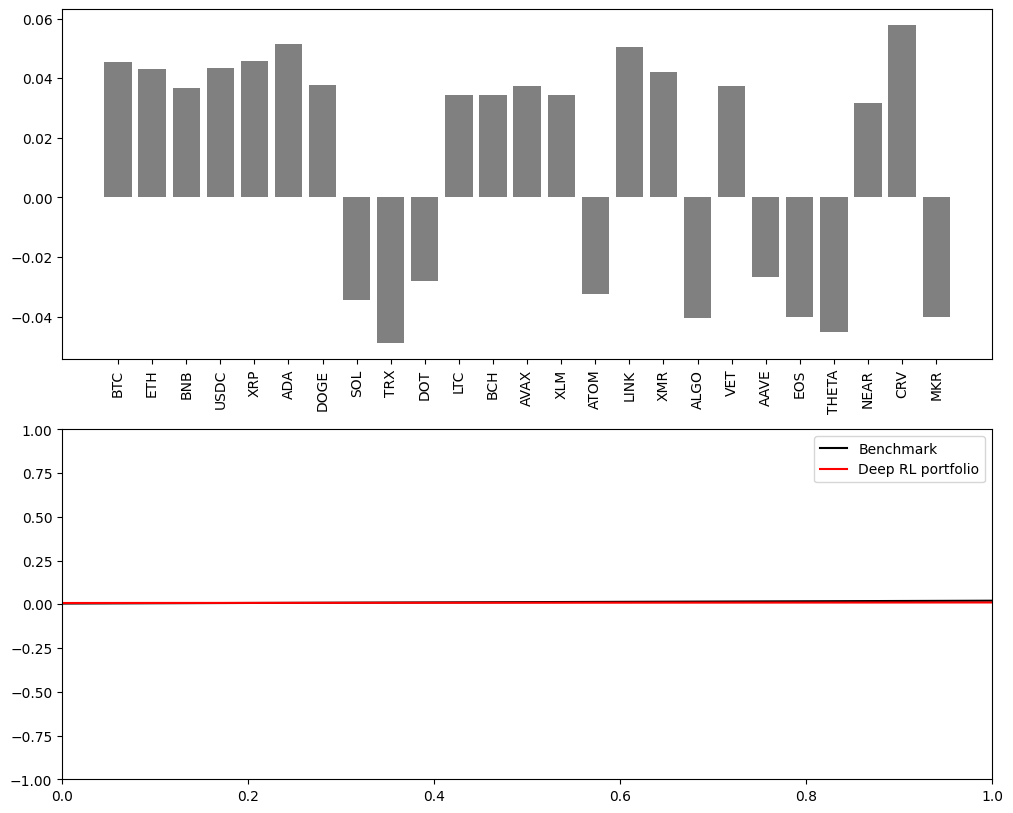

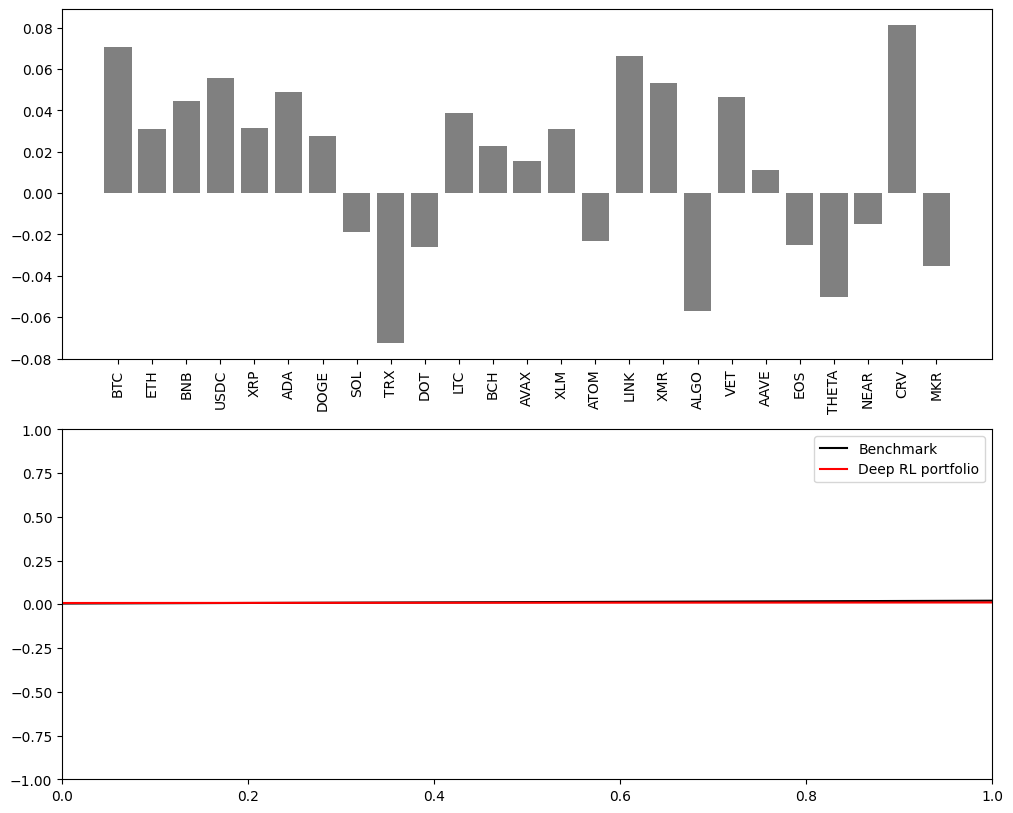

In [ ]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum())

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.colormaps = current_cmap
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()

In [ ]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [ ]:
print('benchmark', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

NameError: name 'print_stats' is not defined